# Generative Models
***

**Autumn 2023, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


Let's continue our dive into the classical generative models! Today's goal is to implement Conditional GAN for MNIST dataset. Conditional image generation is the task of generating new images conditional on their class. Feel free to rewrite this skeleton or reuse your code from the previous assignment.

Good luck!

## 1. Conditional GAN
*Source: <a href="https://arxiv.org/pdf/1411.1784.pdf" target="_blank">Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014)</a>.*

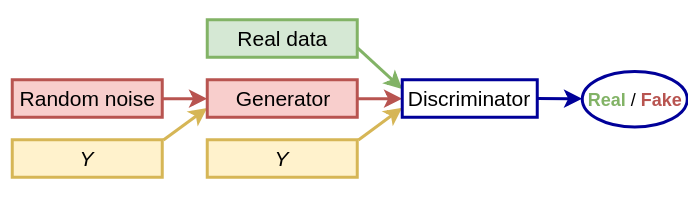

Picture source: https://medium.datadriveninvestor.com/an-introduction-to-conditional-gans-cgans-727d1f5bb011

### Imports

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image
from PIL import Image as IMO

%matplotlib inline
plt.style.use("ggplot")

### Some parameters

In [2]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"
number_class = 10

if device == "cuda":
    !nvidia-smi

sample_dir = "./images"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### Load dataset and create dataloader

In [3]:
# Load MNIST dataset
mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [4]:
# plot pixels distribution
img, label = mnist[0]
print('Label: ', label)
# Your code here

Label:  5


In [5]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    # Your code here
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label:  5
Label: 5


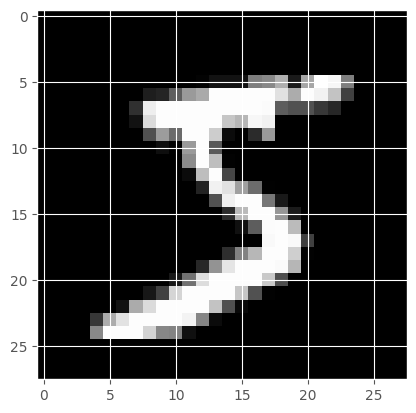

In [6]:
# Let's plot something
img, label = mnist[0]
print("Label: ", label)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap="gray")
print("Label:", label)

### Define the models

Define the Discriminator network, the Generator network with additional input for condition

In [7]:
number_class = 10

class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size, number_class): # pass number_class and use nn.Embedding here
        # linear1 - relu - linear2 - relu - linear3 - tanh
        super(Generator, self).__init__()
        # Your code here!
        self.label_emb = nn.Embedding(number_class, latent_size)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(2*latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, image_size)


    def forward(self, x, label):
        # concat label embedding with random latent vector
        # Your code here!
        label = self.label_emb(label).reshape(x.size())
        x = torch.cat([x, label], dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = torch.tanh(self.fc3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, latent_size, number_class): # pass number_class and use nn.Embedding here
        # linear1 - leaky_relu - linear2 - leaky_relu - linear3 - sigmoid
        super(Discriminator, self).__init__()
        # Your code here!
        self.label_emb = nn.Embedding(number_class, latent_size)
        self.dropout = nn.Dropout(p=0.4)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.fc1 = nn.Linear(image_size + latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x, label):
        # concat label embedding with input image
        # Your code here!
        label = self.label_emb(label).reshape(x.size()[0], self.label_emb.embedding_dim)
        x = torch.cat((x, label), 1)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

Answer the question: why the last layer of generator is $Tanh$ and the last discriminator layer is $Sigmoid$?

In [8]:
# create new Generator model

G = Generator(latent_size, image_size, hidden_size, number_class)

# create new Discriminator model

D = Discriminator(image_size, hidden_size//2, latent_size//2, number_class)

In [9]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR*10)
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR)

### Discriminator Training

In [10]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images, labels):
    # Loss for real images
    real_labels = torch.ones(batch_size, 1).to(device)

    # Your code here!
    real_outputs = D(images, labels)
    d_loss_real = criterion(real_outputs, real_labels)
    real_score = real_outputs

    # Loss for fake images
    gens_label = torch.randint(0, 9, (batch_size,1)).to(device)
    z = torch.randn(batch_size, latent_size).to(device) + gens_label
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Your code here!
    fake_images = G(z, gens_label)
    fake_outputs = D(fake_images, gens_label)
    d_loss_fake = criterion(fake_outputs, fake_labels)
    fake_score = fake_outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    # Your code here!

    # Reset gradients
    reset_grad()

    # Compute gradients

    # Your code here!
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

### Generator Training

In [11]:
def train_generator():
    #g_optimizer.zero_grad()

    # Sample random vector
    gens_label = torch.randint(0, 9, (batch_size,1)).to(device)
    z = torch.randn(batch_size, latent_size).to(device) + gens_label

    # Generate fake images and calculate loss
    # Your code here!
    fake_images = G(z, gens_label)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images, gens_label), labels)

    # Backprop and optimize
    reset_grad()

    # Your code here!
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [12]:
def save_fake_images(index):
    # Sample random vector
    gens_label = torch.randint(0, 9, (batch_size,1)).to(device)
    sample_vectors = torch.randn(batch_size, latent_size).to(device) + gens_label
    # Generate images with Generator
    fake_images = G(sample_vectors, gens_label)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [13]:
%%time
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, digit) in enumerate(dataloader):
        # Load a batch & transform to vectors
        # Your code here!
        images = images.reshape(batch_size, -1).to(device)
        digit = digit.to(device)

        # Train the discriminator and generator
        # Your code here!
        d_loss, real_score, fake_score = train_discriminator(images, digit)
        # Train the generator
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images(epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.0340, g_loss: 17.6268, D(x): 0.99, D(G(z)): 0.00
Epoch [0/300], Step [400/600], d_loss: 0.2662, g_loss: 20.8241, D(x): 0.91, D(G(z)): 0.01
Epoch [0/300], Step [600/600], d_loss: 0.1487, g_loss: 16.1563, D(x): 0.95, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 1.0592, g_loss: 5.8757, D(x): 0.68, D(G(z)): 0.10
Epoch [1/300], Step [400/600], d_loss: 0.5518, g_loss: 8.7051, D(x): 0.84, D(G(z)): 0.16
Epoch [1/300], Step [600/600], d_loss: 0.6309, g_loss: 3.4735, D(x): 0.76, D(G(z)): 0.15
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.8276, g_loss: 2.3386, D(x): 0.80, D(G(z)): 0.30
Epoch [2/300], Step [400/600], d_loss: 0.5753, g_loss: 2.7232, D(x): 0.83, D(G(z)): 0.18
Epoch [2/300], Step [600/600], d_loss: 0.3825, g_loss: 3.8772, D(x): 0.92, D(G(z)): 0.15
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.5419, g_loss: 2.9790, D(x): 0.83, D(G(z)): 0.14
Epoch [3/300], Step [40

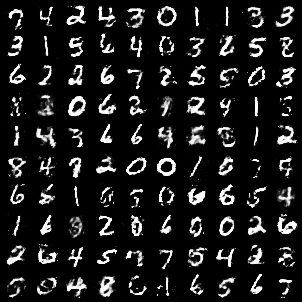

In [20]:
# show output after epochs training
IMO.open(os.path.join(sample_dir, "fake_images-0300.png"))

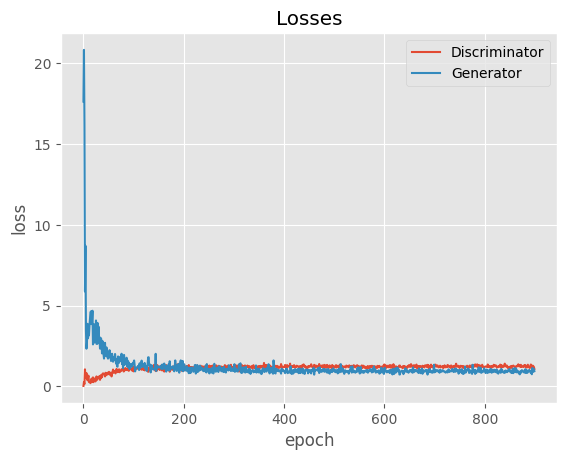

In [15]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

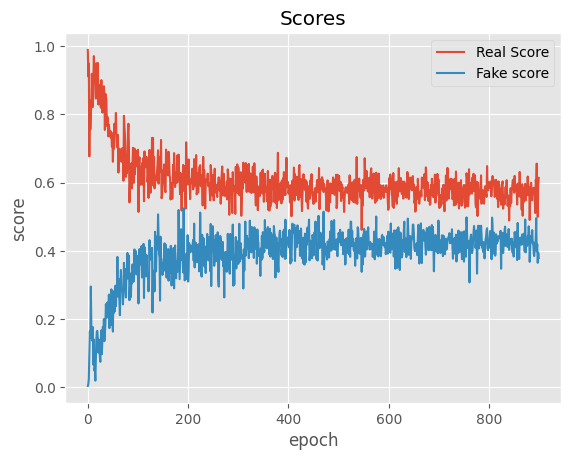

In [16]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

### Show your conditional generation results for each class independently

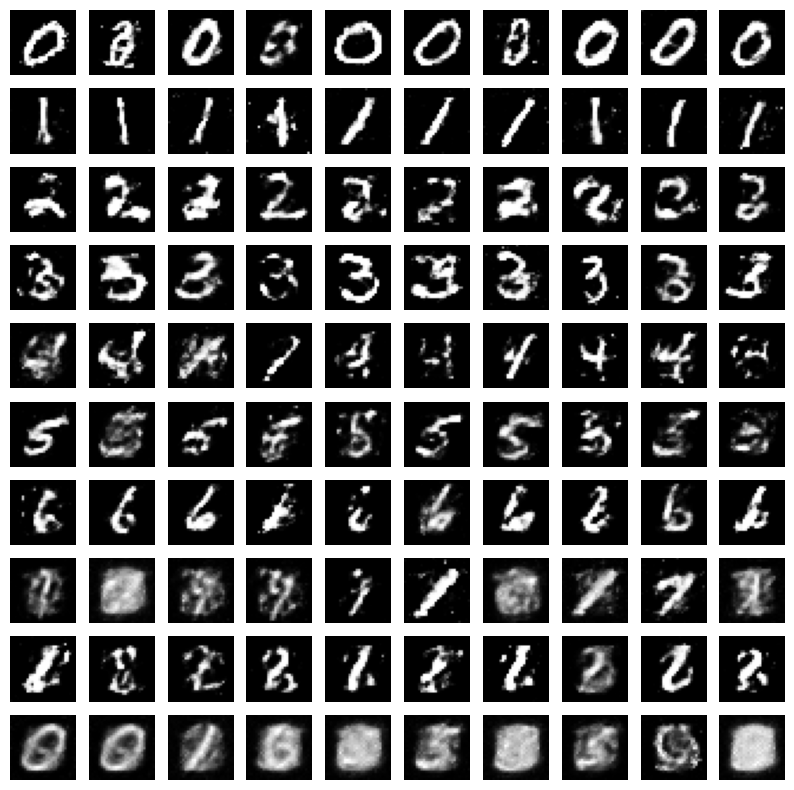

In [24]:
import matplotlib.pyplot as plt

num_classes = 10  
num_samples = 10  

fig, axs = plt.subplots(num_classes, num_samples, figsize=(num_samples, num_classes))

for class_label in range(num_classes):
    z = torch.randn(num_samples, latent_size).to(device)
    fake_labels = torch.full((num_samples,), class_label, dtype=torch.int64).to(device)
    fake_images = G(z, fake_labels)

    # Rescale and save the generated images
    fake_images = fake_images.view(-1, 28, 28).cpu().detach().numpy()
    for i in range(num_samples):
        axs[class_label, i].imshow(fake_images[i], cmap='gray')
        axs[class_label, i].axis('off')

plt.show()